## 1. Data Prep

In [6]:
# Seed value
seed_value= 60

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# tf.compat.v1.set_random_seed(seed_value)

In [7]:
from __future__ import print_function
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding,LSTM, SimpleRNN, GRU,UpSampling1D, Layer, InputSpec
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler, OneHotEncoder,Binarizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import initializers

In [8]:
traindata = pd.read_csv('data/UNSW_NB15_training-set.csv')
testdata = pd.read_csv('data/UNSW_NB15_testing-set.csv')
traindata = traindata.drop('id', axis=1)
testdata = testdata.drop('id', axis=1)
print(traindata.shape, testdata.shape)

(82332, 44) (175341, 44)


### handle null values in service column

In [9]:
print(traindata['service'].value_counts())
print(testdata['service'].value_counts())

-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64


In [10]:
traindata['service'].replace('-',np.nan,inplace=True)
testdata['service'].replace('-',np.nan,inplace=True)
print(traindata['service'].isna().sum()) # 47153 out of 82332
print(testdata['service'].isna().sum()) # 94168 out of 175341

47153
94168


In [11]:
traindata = traindata.drop(['service'],axis=1)
testdata = testdata.drop(['service'],axis=1)

In [12]:
print(traindata.groupby("label").size())
print(testdata.groupby("label").size())
print("############multi-class##########################")
print(traindata.groupby("attack_cat").size())
print(testdata.groupby("attack_cat").size())

label
0    37000
1    45332
dtype: int64
label
0     56000
1    119341
dtype: int64
############multi-class##########################
attack_cat
Analysis            677
Backdoor            583
DoS                4089
Exploits          11132
Fuzzers            6062
Generic           18871
Normal            37000
Reconnaissance     3496
Shellcode           378
Worms                44
dtype: int64
attack_cat
Analysis           2000
Backdoor           1746
DoS               12264
Exploits          33393
Fuzzers           18184
Generic           40000
Normal            56000
Reconnaissance    10491
Shellcode          1133
Worms               130
dtype: int64


In [13]:
for c in range(1,4):
    traindata.iloc[:,c] = LabelEncoder().fit_transform(traindata.iloc[:,c])
    testdata.iloc[:,c] = LabelEncoder().fit_transform(testdata.iloc[:,c])
train_x = traindata.iloc[:,0:41]
train_y_b = traindata.iloc[:,-1]
train_y_m = traindata.iloc[:,-2]
test_x = testdata.iloc[:,0:41]
test_y_b = testdata.iloc[:,-1]
test_y_m = testdata.iloc[:,-2]

In [14]:
train_y_mtl = pd.get_dummies(train_y_m)
test_y_mtl = pd.get_dummies(test_y_m)
train_y_mtl.columns.to_list()

['Analysis',
 'Backdoor',
 'DoS',
 'Exploits',
 'Fuzzers',
 'Generic',
 'Normal',
 'Reconnaissance',
 'Shellcode',
 'Worms']

In [15]:
from keras.metrics import Precision as k_precision, Recall as k_recall
from keras.metrics import PrecisionAtRecall, TruePositives as tp, TrueNegatives as tn, FalseNegatives as fn, FalsePositives as fp

## 2. Feature Selection & correlation Analysis

In [16]:
#Lasso - correlation analysis for individual tasks
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskElasticNet
def feature_selection(x,y): 
    lasso_selection = Lasso(alpha=0.2)
    lasso_coef = lasso_selection.fit(x,y).coef_
    print('Selected features: ',str(len(lasso_coef[lasso_coef!=0.0])))

    # Making a list from selected features
    val = lasso_coef[lasso_coef!=0.0]
    key, = np.where(lasso_coef!=0.0)
    feature_list = x.columns[key]
    val_plt = np.multiply(val,1000)
    feature_list = feature_list.tolist()
    feature_column = key.tolist()
    val = val.tolist()
    print(feature_list)
    return x[feature_list]

############ [to create individual set for each task] ############  
#for col in list(train_y_mtl):
#    globals()[f"x_{col}"] = feature_selection(train_x, train_y_mtl[col])


In [17]:
#Lasso - feature selection for MTL
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskElasticNet
import matplotlib.pyplot as plt
def multitask_lasso_selection(X,Y,col_list):
    #coef_lasso_ = np.array([Lasso(alpha=1, tol=0.001, max_iter=1000000000).fit(X, y).coef_ for y in Y.T])
    coef_multi_task_lasso_ = MultiTaskElasticNet(alpha=1,l1_ratio=0.4).fit(X, Y).coef_ #0.05-32 0.1-27 0.2-26 0.3-24; original setting: (alpha=1.0,l1_ratio=1)
    #select features
    select = []
    for i in range(len(coef_multi_task_lasso_)):
        for j in range(len(coef_multi_task_lasso_[0])):
            if coef_multi_task_lasso_[i,j] != 0 and col_list[j] not in select:
                select.append(col_list[j])
    #plotting
    """
    fig = plt.figure(figsize=(10, 10))
    coef = np.zeros((len(Y[0]), len(X[0])))
    feature_to_plot = 0
    plt.figure()
    lw = 2
    plt.plot(coef[:, feature_to_plot], color="yellow", linewidth=lw, label="Ground truth")
    plt.plot(coef_lasso_[:, feature_to_plot], color="blue", linewidth=lw, label="Lasso")
    plt.plot(coef_multi_task_lasso_[:, feature_to_plot], color="red", linewidth=lw, label="MultiTaskLasso")
    print(np.max(coef_multi_task_lasso_[:, feature_to_plot]))
    plt.legend(loc="upper center")
    plt.ylim(-4E-10,4E-10)
    plt.show()
    """
    return(select)

multitask_lasso = multitask_lasso_selection(np.array(train_x),np.array(train_y_mtl),train_x.columns)
print(multitask_lasso)
dim = len(multitask_lasso)

['proto', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'smean', 'dmean', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_srv_dst']


c:\Users\karen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2403: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.89237538895395, tolerance: 5.906438978768886
  ) = cd_fast.enet_coordinate_descent_multi_task(


In [18]:
mtl_train_x_lasso = train_x[multitask_lasso]
mtl_test_x_lasso = test_x[multitask_lasso]
mtl_train_x_lasso = np.array(mtl_train_x_lasso)
mtl_test_x_lasso = np.array(mtl_test_x_lasso)
mtl_train_x_lasso.astype(float)
mtl_test_x_lasso.astype(float)
scaler_lasso = Normalizer().fit(mtl_train_x_lasso)
mtl_train_x_lasso = scaler_lasso.transform(mtl_train_x_lasso)
scaler_lasso = Normalizer().fit(mtl_test_x_lasso)
mtl_test_x_lasso = scaler_lasso.transform(mtl_test_x_lasso)

mtl_train_y_b = np.array(train_y_b)
mtl_train_y = np.array(train_y_mtl)
mtl_test_y_b = np.array(test_y_b)
mtl_test_y = np.array(test_y_mtl)



In [19]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
print(sorted(Counter(train_y_m).items()))
#SMOTETomek(sampling_strategy="not minority",smote=SMOTE(random_state=42),random_state=42)
multi_st = SMOTEENN(sampling_strategy="all",smote=SMOTE(random_state=42),random_state=42)
multi_x_try, multi_y_try = multi_st.fit_resample(mtl_train_x_lasso,train_y_m)
print(sorted(Counter(multi_y_try).items()))


[('Analysis', 677), ('Backdoor', 583), ('DoS', 4089), ('Exploits', 11132), ('Fuzzers', 6062), ('Generic', 18871), ('Normal', 37000), ('Reconnaissance', 3496), ('Shellcode', 378), ('Worms', 44)]
[('Analysis', 14320), ('Backdoor', 3157), ('DoS', 5611), ('Exploits', 8639), ('Fuzzers', 10162), ('Generic', 35650), ('Normal', 17105), ('Reconnaissance', 16473), ('Shellcode', 17742), ('Worms', 25089)]


In [20]:
weights_temp = []
sumw = 0
for i in sorted(Counter(multi_y_try).items()):
    sumw += i[1]
    weights_temp.append(i[1])
weights_task = []
for i in weights_temp:
    weights_task.append(sumw/i)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
print(NormalizeData(weights_task))

[0.14472135 1.         0.52015164 0.30378195 0.24369204 0.
 0.10533884 0.11310785 0.09806844 0.04089841]


In [21]:
multi_y_try = pd.get_dummies(multi_y_try)
multi_y_try.columns

Index(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
      dtype='object')

In [22]:
scaler_train = Normalizer().fit(multi_x_try)
multi_x_try = scaler_train.transform(multi_x_try)
scaler_test = Normalizer().fit(mtl_test_x_lasso)
mtl_test_x_lasso = scaler_test.transform(mtl_test_x_lasso)

In [23]:
print(multi_x_try.shape)
print(multi_y_try.shape)
print(mtl_test_x_lasso.shape)
print(mtl_test_y.shape)

(153948, 24)
(153948, 10)
(175341, 24)
(175341, 10)


In [24]:
for i in range(10):
    idx = ['Analysis',
            'Backdoor',
            'DoS',
            'Exploits',
            'Fuzzers',
            'Generic',
            'Normal',
            'Reconnaissance',
            'Shellcode',
            'Worms']
    temp_train_y = pd.DataFrame(multi_y_try,columns=idx)
    temp_test_y = pd.DataFrame(mtl_test_y,columns=idx)
    globals()[f"t_train_{idx[i]}"] = np.array(temp_train_y[idx[i]])
    globals()[f"t_test_{idx[i]}"] = np.array(temp_test_y[idx[i]])
    print(f"t_train_{idx[i]}")
    print(f"t_test_{idx[i]}")

t_train_Analysis
t_test_Analysis
t_train_Backdoor
t_test_Backdoor
t_train_DoS
t_test_DoS
t_train_Exploits
t_test_Exploits
t_train_Fuzzers
t_test_Fuzzers
t_train_Generic
t_test_Generic
t_train_Normal
t_test_Normal
t_train_Reconnaissance
t_test_Reconnaissance
t_train_Shellcode
t_test_Shellcode
t_train_Worms
t_test_Worms


## 3. mtl-with-keras


### STL base model - CNN-AE

In [30]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Input, Layer
from keras import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def define_base_model(input_dim, unit_minimum=16):
    inputs = Input(shape=(input_dim, 1))

    # Define an input sequence and process it.
    x_1 = Conv1D(unit_minimum*4, 3, activation='relu', padding='same')(inputs)
    x_1 = MaxPooling1D(2, padding='same')(x_1)
    x_2 = Conv1D(unit_minimum*2, 3, activation='relu', padding='same')(x_1)
    x_2 = MaxPooling1D(2, padding='same')(x_2)
    x_3 = Conv1D(unit_minimum, 3, activation='relu', padding='same')(x_2)
    encoder = MaxPooling1D(2, padding='same')(x_3)
    x_4 = Conv1D(unit_minimum, 3, activation='relu', padding='same')(encoder)
    x_4 = UpSampling1D(2)(x_4)
    x_5 = Conv1D(unit_minimum*2, 3, activation='relu', padding='same')(x_4)
    x_5 = UpSampling1D(2)(x_5)
    x_6 = Conv1D(unit_minimum*4, 3, activation='relu', padding='same')(x_5)
    decoder = UpSampling1D(2)(x_5)
    full = Flatten(name="full")(decoder)
    output_binary = Dense(1, activation="sigmoid", name='output_binary')(full)

    # Full model
    model = Model(inputs=inputs, outputs=output_binary)
    model.compile(Adam(learning_rate=0.0001), loss=BinaryCrossentropy(from_logits=False,label_smoothing=0.1), 
                metrics=['accuracy',k_recall(thresholds=0.5), PrecisionAtRecall(recall=0.5), tp(thresholds=0.5), tn(thresholds=0.5), fp(thresholds=0.5), fn(thresholds=0.5)])
    model.summary()
    return model

stl = define_base_model(dim)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 24, 64)            256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 12, 32)            6176      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 6, 16)             1552

In [31]:
##### for optimization 
class SWA(callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))     
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  
        else:
            pass
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        self.model.save_weights(self.filepath)
        if self.filepath:
            self.model.save_weights(self.filepath)
            print('Final stochastic averaged weights saved to file.')

swa = SWA(filepath='./mtlkeras_test/swa_cnn.model',swa_epoch=90)

In [ ]:
stl.fit(multi_x_try, t_train_Normal, 
        validation_data=(mtl_test_x_lasso,t_test_Normal),                          
        batch_size=128, epochs=100, verbose=2, 
        callbacks=[swa,ModelCheckpoint(filepath="mtlkeras_test/stl-checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True,monitor='val_accuracy',mode='max'),CSVLogger('stl_training_set_iranalysis.csv',separator=',', append=False)])
e = stl.evaluate(mtl_test_x_lasso,t_test_Normal)

In [35]:
stl = load_model('./mtlkeras_test/stl_model_cnnae.h5')
stl.load_weights('./mtlkeras_test/swa_cnn.model')
evaluation = stl.evaluate(mtl_test_x_lasso,t_test_Normal)

5480/5480 [==============================] - 6s 1ms/step - loss: 0.4892 - accuracy: 0.8774 - recall: 0.6216 - precision_at_recall: 0.9995 - true_positives: 34808.0000 - true_negatives: 119037.0000 - false_positives: 304.0000 - false_negatives: 21192.0000


In [36]:
#binary_loss, binary_accuracy, recall, precision_at_recall, b_tp, b_tn, b_fp, b_fn = stl_e
#reverse for binary intrusion detection
binary_loss, binary_accuracy, recall, precision_at_recall, b_tn, b_tp, b_fn, b_fp = evaluation
    #acc, precision, recall, fpr
print(binary_loss, (b_tp+b_tn)/(b_tp+b_fp+b_tn+b_fn), b_tp/(b_tp+b_fp), b_tp/(b_tp+b_fn), b_fp/(b_fp+b_tn))

0.48921820521354675 0.8774046001790796 0.8488757674945981 0.9974526776212701 0.37842857142857145


### build mtl from base

In [38]:
def full_mtl_model(base_model):
    feature_extractor_layer = base_model.get_layer('full').output

    net_Analysis = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Analysis = Dense(1, activation='sigmoid', name='output_Analysis')(net_Analysis)

    net_Backdoor = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Backdoor = Dense(1, activation='sigmoid', name='output_Backdoor')(net_Backdoor)

    net_DoS = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_DoS = Dense(1, activation='sigmoid', name='output_DoS')(net_DoS)

    net_Exploits = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Exploits = Dense(1, activation='sigmoid', name='output_Exploits')(net_Exploits)

    net_Fuzzers = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Fuzzers = Dense(1, activation='sigmoid', name='output_Fuzzers')(net_Fuzzers)

    net_Generic = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Generic = Dense(1, activation='sigmoid', name='output_Generic')(net_Generic)

    net_Reconnaissance = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Reconnaissance = Dense(1, activation='sigmoid', name='output_Reconnaissance')(net_Reconnaissance)

    net_Shellcode = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Shellcode = Dense(1, activation='sigmoid', name='output_Shellcode')(net_Shellcode)

    net_Worms = Dense(32, kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu')(feature_extractor_layer)
    output_Worms = Dense(1, activation='sigmoid', name='output_Worms')(net_Worms)
    """
    output_Analysis = Dense(1, activation='sigmoid', name='output_Analysis')(feature_extractor_layer)
    output_Backdoor = Dense(1, activation='sigmoid', name='output_Backdoor')(feature_extractor_layer)
    output_DoS = Dense(1, activation='sigmoid', name='output_DoS')(feature_extractor_layer)
    output_Exploits = Dense(1, activation='sigmoid', name='output_Exploits')(feature_extractor_layer)
    output_Fuzzers = Dense(1, activation='sigmoid', name='output_Fuzzers')(feature_extractor_layer)
    output_Generic = Dense(1, activation='sigmoid', name='output_Generic')(feature_extractor_layer)
    #output_normal = Dense(1, activation='sigmoid', name='output_normal')(feature_extractor_layer)
    output_Reconnaissance = Dense(1, activation='sigmoid', name='output_Reconnaissance')(feature_extractor_layer)
    output_Shellcode = Dense(1, activation='sigmoid', name='output_Shellcode')(feature_extractor_layer)
    output_Worms = Dense(1, activation='sigmoid', name='output_Worms')(feature_extractor_layer)
    """
    target_model = Model(inputs=base_model.input, outputs=[output_Analysis,
                                            output_Backdoor,
                                            output_DoS,
                                            output_Exploits,
                                            output_Fuzzers,
                                            output_Generic,
                                            #output_normal,
                                            output_Reconnaissance,
                                            output_Shellcode,
                                            output_Worms])

    opt = Adam(clipnorm = 1.)
    loss = {'output_Analysis': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_Backdoor': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_DoS': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_Exploits': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_Fuzzers': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_Generic': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				#'output_normal': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_Reconnaissance': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_Shellcode': BinaryCrossentropy(from_logits=False,label_smoothing=0.1),
				'output_Worms': BinaryCrossentropy(from_logits=False,label_smoothing=0.1)}
    loss_weights = {'output_Analysis': weights_task[0],
						'output_Backdoor': weights_task[1],
						'output_DoS': weights_task[2],
						'output_Exploits': weights_task[3],
						'output_Fuzzers': weights_task[4],
						'output_Generic': weights_task[5],
						#'output_normal': weights_task[6],
						'output_Reconnaissance': weights_task[7],
						'output_Shellcode': weights_task[8],
						'output_Worms': weights_task[9]}
    target_model.compile(Adam(learning_rate=0.001),loss=loss,loss_weights=loss_weights,
						metrics=['accuracy',k_recall(thresholds=0.5), PrecisionAtRecall(recall=0.8), tp(thresholds=0.5), tn(thresholds=0.5), fp(thresholds=0.5), fn(thresholds=0.5)]
		)
    return target_model


In [50]:
mtl = full_mtl_model(stl)
mtl.summary()

for layer in mtl.layers[:13]:
    layer.trainable = False
for layer in mtl.layers[13:]:
    layer.trainable = True

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 64)       256         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 12, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 12, 32)       6176        ['max_pooling1d[0][0]']          
                                                                                            

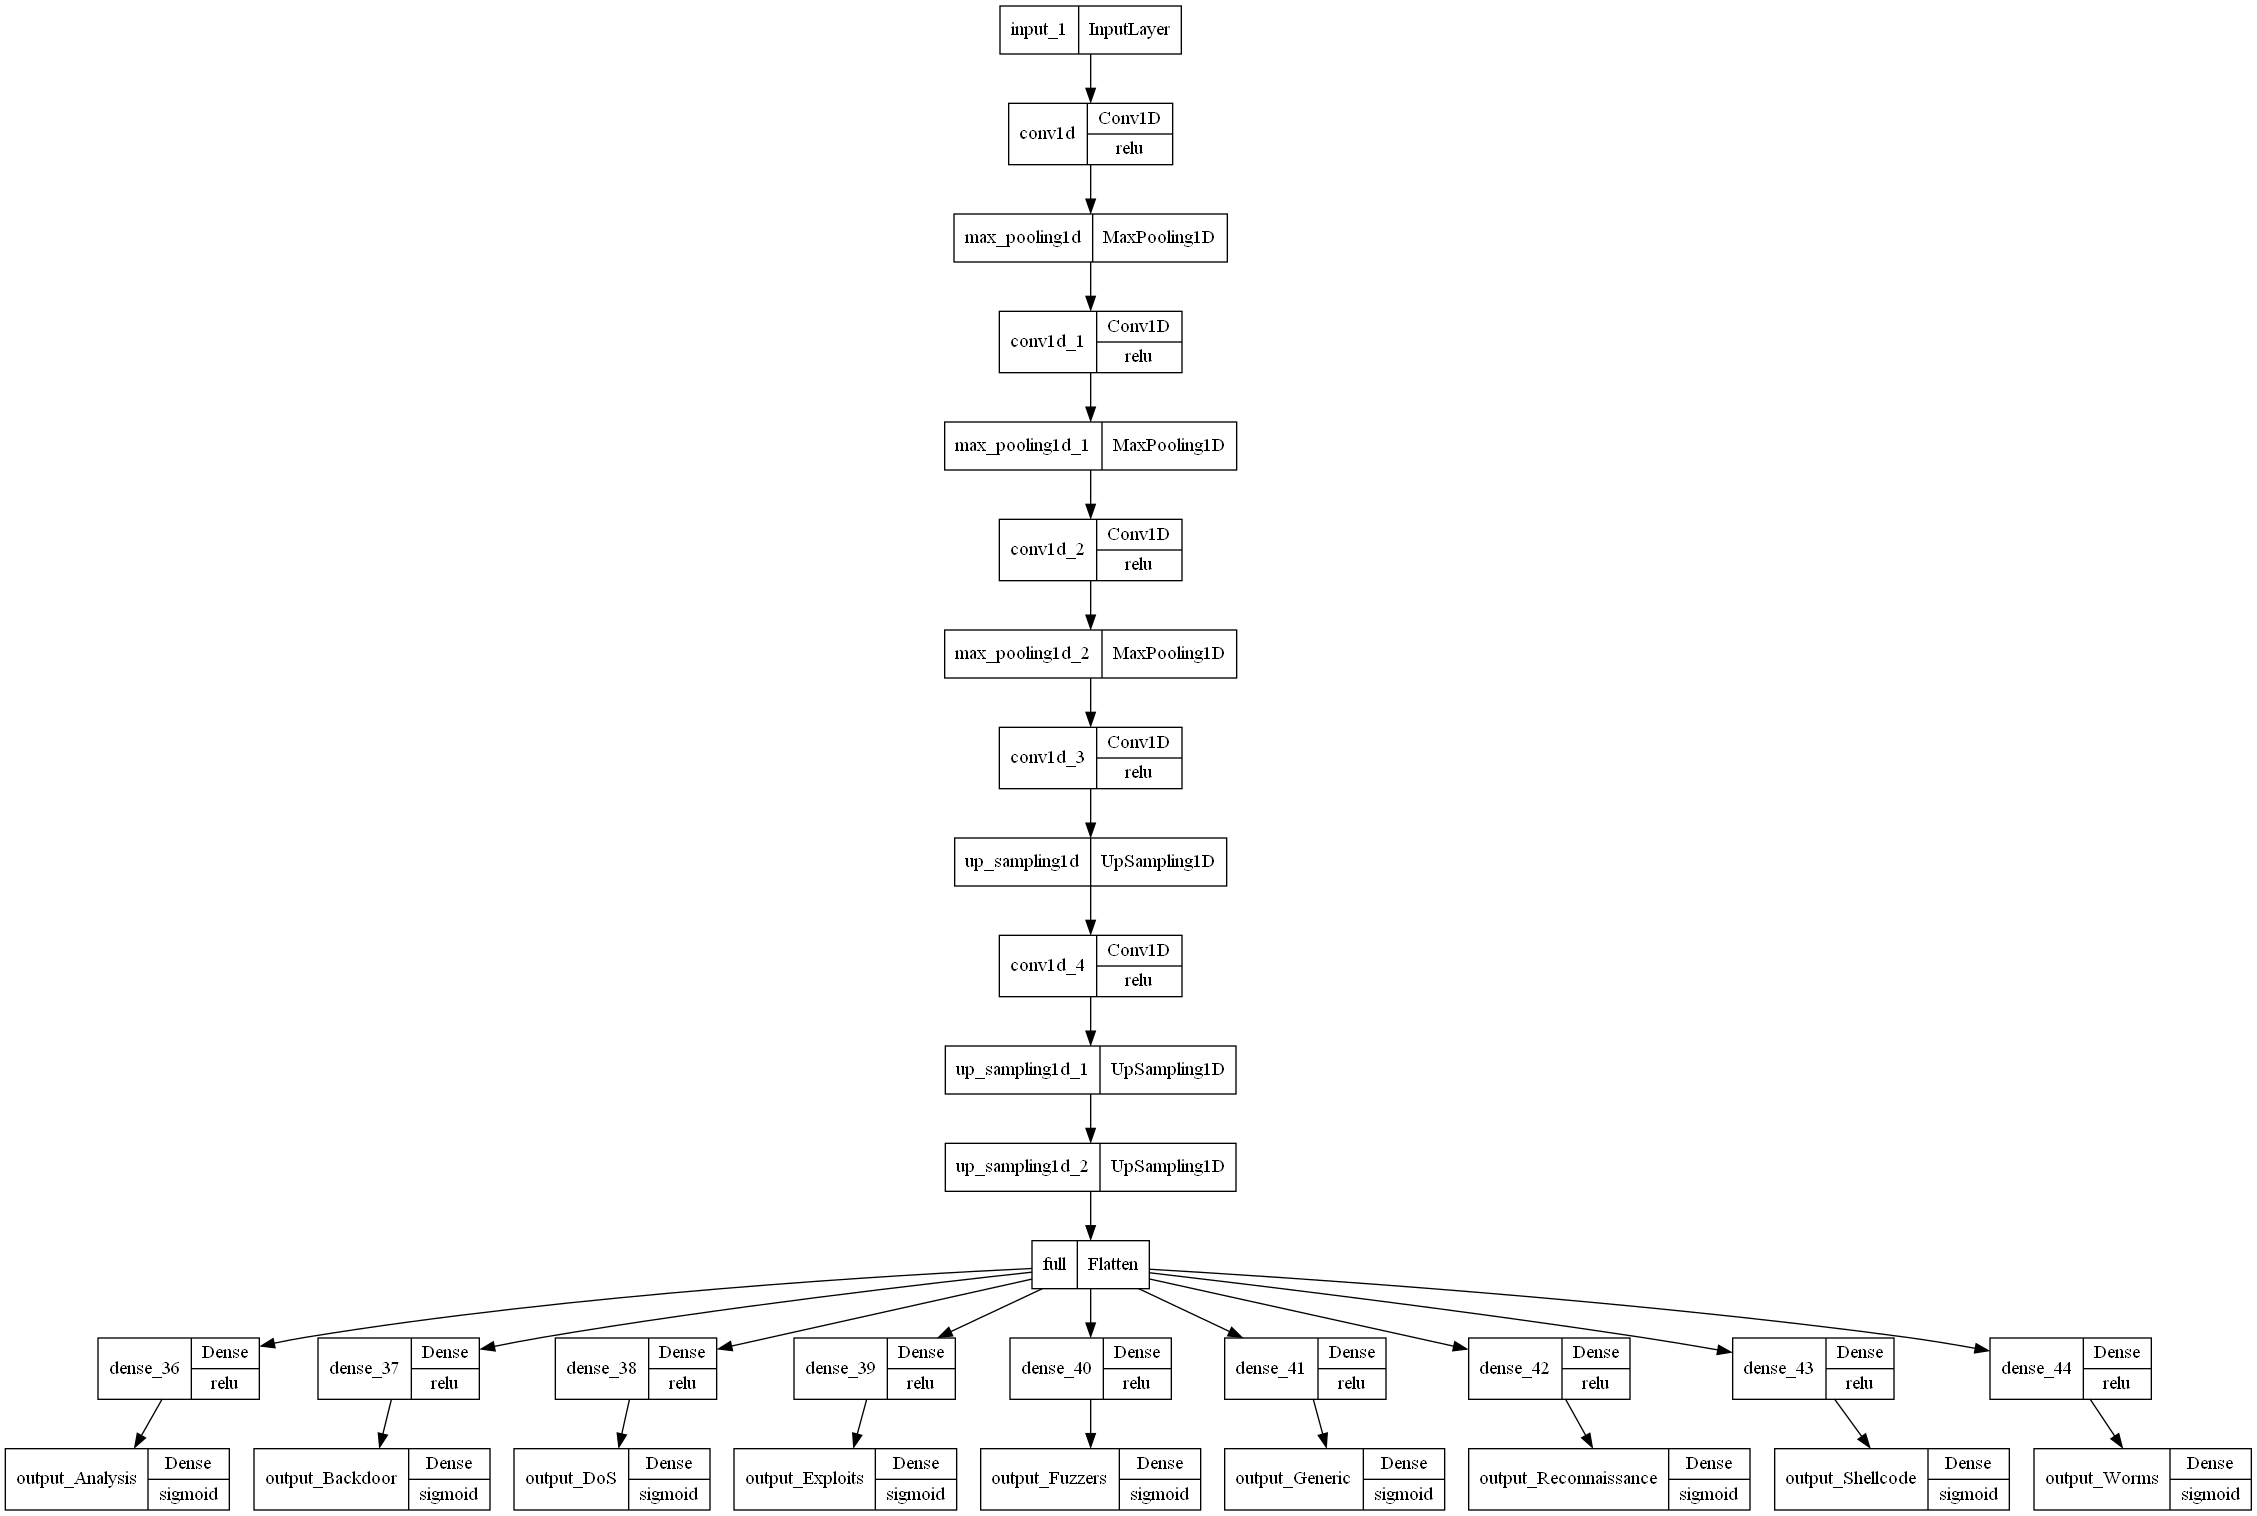

In [51]:
from keras.utils.vis_utils import plot_model
dot_img_file = 'mtl_cnn_ae.png'
plot_model(mtl, to_file=dot_img_file, show_shapes=False,show_layer_activations=True,show_layer_names=True, show_dtype=False)

In [52]:
swa_mtl = SWA(filepath='./mtlkeras_test/swa_mtl.model',swa_epoch=90)

In [53]:
mtl.fit(multi_x_try, [t_train_Analysis,t_train_Backdoor,t_train_DoS,t_train_Exploits,t_train_Fuzzers,t_train_Generic,t_train_Reconnaissance,t_train_Shellcode,t_train_Worms], 
    validation_data=(mtl_test_x_lasso,[t_test_Analysis,t_test_Backdoor,t_test_DoS,t_test_Exploits,t_test_Fuzzers,t_test_Generic,t_test_Reconnaissance,t_test_Shellcode,t_test_Worms]),
    batch_size = 64, epochs = 100, verbose = True, shuffle = True, 
    callbacks=[swa_mtl,ModelCheckpoint(filepath="mtlkeras_test/stl-checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True,monitor='val_accuracy',mode='max'),CSVLogger('stl_training_set_iranalysis.csv',separator=',', append=False)])


Stochastic weight averaging selected for last 10 epochs.
Epoch 1/100
2406/2406 [==============================] - 40s 14ms/step - loss: 38.5510 - output_Analysis_loss: 0.2687 - output_Backdoor_loss: 0.2286 - output_DoS_loss: 0.2614 - output_Exploits_loss: 0.2763 - output_Fuzzers_loss: 0.2976 - output_Generic_loss: 0.2167 - output_Reconnaissance_loss: 0.2553 - output_Shellcode_loss: 0.3014 - output_Worms_loss: 0.3215 - output_Analysis_accuracy: 0.9534 - output_Analysis_recall_5: 0.8611 - output_Analysis_precision_at_recall_5: 0.7063 - output_Analysis_true_positives_5: 12331.0000 - output_Analysis_true_negatives_5: 134448.0000 - output_Analysis_false_positives_5: 5180.0000 - output_Analysis_false_negatives_5: 1989.0000 - output_Backdoor_accuracy: 0.9865 - output_Backdoor_recall_5: 0.4086 - output_Backdoor_precision_at_recall_5: 0.1381 - output_Backdoor_true_positives_5: 1290.0000 - output_Backdoor_true_negatives_5: 150579.0000 - output_Backdoor_false_positives_5: 212.0000 - output_Backdo

In [54]:
pred_mtl = mtl.predict(mtl_test_x_lasso)
evaluation_mtl = mtl.evaluate(mtl_test_x_lasso,[t_test_Analysis,t_test_Backdoor,t_test_DoS,t_test_Exploits,t_test_Fuzzers,t_test_Generic,t_test_Reconnaissance,t_test_Shellcode,t_test_Worms])
print(evaluation_mtl)

5480/5480 [==============================] - 30s 5ms/step - loss: 48.7269 - output_Analysis_loss: 0.3582 - output_Backdoor_loss: 0.2352 - output_DoS_loss: 0.3492 - output_Exploits_loss: 0.5711 - output_Fuzzers_loss: 0.3892 - output_Generic_loss: 0.2127 - output_Reconnaissance_loss: 0.2937 - output_Shellcode_loss: 0.2448 - output_Worms_loss: 0.3206 - output_Analysis_accuracy: 0.8609 - output_Analysis_recall_5: 0.6685 - output_Analysis_precision_at_recall_5: 0.0227 - output_Analysis_true_positives_5: 1337.0000 - output_Analysis_true_negatives_5: 149610.0000 - output_Analysis_false_positives_5: 23731.0000 - output_Analysis_false_negatives_5: 663.0000 - output_Backdoor_accuracy: 0.9841 - output_Backdoor_recall_5: 0.0424 - output_Backdoor_precision_at_recall_5: 0.0395 - output_Backdoor_true_positives_5: 74.0000 - output_Backdoor_true_negatives_5: 172480.0000 - output_Backdoor_false_positives_5: 1115.0000 - output_Backdoor_false_negatives_5: 1672.0000 - output_DoS_accuracy: 0.9240 - output_D

In [63]:
def rates(tp, tn, fp, fn):
	acc = (tp+tn)/(tp+fp+tn+fn)
	precision = tp/(tp+fp)
	recall = tp/(tp+fn)
	fpr = fp/(fp+tn)
	print(f"Accuracy\t {acc:.4f} \nPrecision\t {precision:.4f} \nRecall\t {recall:.4f} \nFPR\t {fpr:.4f}")

for i in range(9):
	idx = ['Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms']
	print(idx[i])
	rates(evaluation_mtl[13+7*i],evaluation_mtl[14+7*i],evaluation_mtl[15+7*i],evaluation_mtl[16+7*i])


Analysis
Accuracy	 0.8609 
Precision	 0.0533 
Recall	 0.6685 
FPR	 0.1369
Backdoor
Accuracy	 0.9841 
Precision	 0.0622 
Recall	 0.0424 
FPR	 0.0064
DoS
Accuracy	 0.9240 
Precision	 0.2092 
Recall	 0.0309 
FPR	 0.0088
Exploits
Accuracy	 0.8065 
Precision	 0.4818 
Recall	 0.2112 
FPR	 0.0534
Fuzzers
Accuracy	 0.8908 
Precision	 0.4423 
Recall	 0.2024 
FPR	 0.0295
Generic
Accuracy	 0.9947 
Precision	 0.9992 
Recall	 0.9775 
FPR	 0.0002
Reconnaissance
Accuracy	 0.9517 
Precision	 0.6772 
Recall	 0.3669 
FPR	 0.0111
Shellcode
Accuracy	 0.9757 
Precision	 0.1235 
Recall	 0.4537 
FPR	 0.0209
Worms
Accuracy	 0.9016 
Precision	 0.0024 
Recall	 0.3231 
FPR	 0.0980
